# **Hands-On Künstliche Intelligenz und quantitative Medizin**
## **Hands-on Deep Learning**

Today we will be diving into some more advanced concepts in machine learning:
*    Supervised learning: Neural Networks
*    Supervised learning: Convolutional Neural Networks

Before you begin reading and editing any code, make sure to make a personal copy of this notebook by clicking `File` --> `Save a Copy in Drive` so you can make changes to the code.

## Imports and loading the dataset
Let's start the necessary `import`s for our code. We will use the wines dataset again (from the previous session) to look at unsupervised dimensionality reduction, and then we will go back to the breast cancer dataset for the supervised learning topics.

**Confused about something?** Raise questions during the session or on Slack! Also remember that you can always Google a function or piece of code that you're not sure about and you will find lots of documentation explaining what is happening.

In [ ]:
# Load the necessary python libraries
from sklearn import preprocessing, decomposition
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_wine, load_breast_cancer
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import graphviz
from graphviz import Source
from IPython.display import SVG
import pandas as pd
import numpy as np
import scipy
import os

%matplotlib inline
plt.style.use('bmh')
plt.rcParams.update({'font.size': 14,
                     'xtick.labelsize' : 14,
                     'ytick.labelsize' : 14,
                     'figure.figsize' : [12,8],
                     })

# **Supervised Learning**: Neural Networks for Classification

Once again, we will be analyzing the breast cancer dataset. We will use decision trees to learn how to predict benign from malignant tumors, and we will investigate how the accuracy changes as we change the depth of the decision tree.

**Reminder:** the breast cancer dataset has 539 tumor cases with 30 features each. Feel free to visualize and plot the features to explore the data

# Training a simple neural network

It's finally time to train our first neural network!

We will train a fully-connected neural network on all the features of our dataset. We will have two hidden layers with 5 and 2 neurons in each layer. Since we have 30 features and binary classification (there are only two output possibilites, tumor or no tumor), our neural network will look like this:


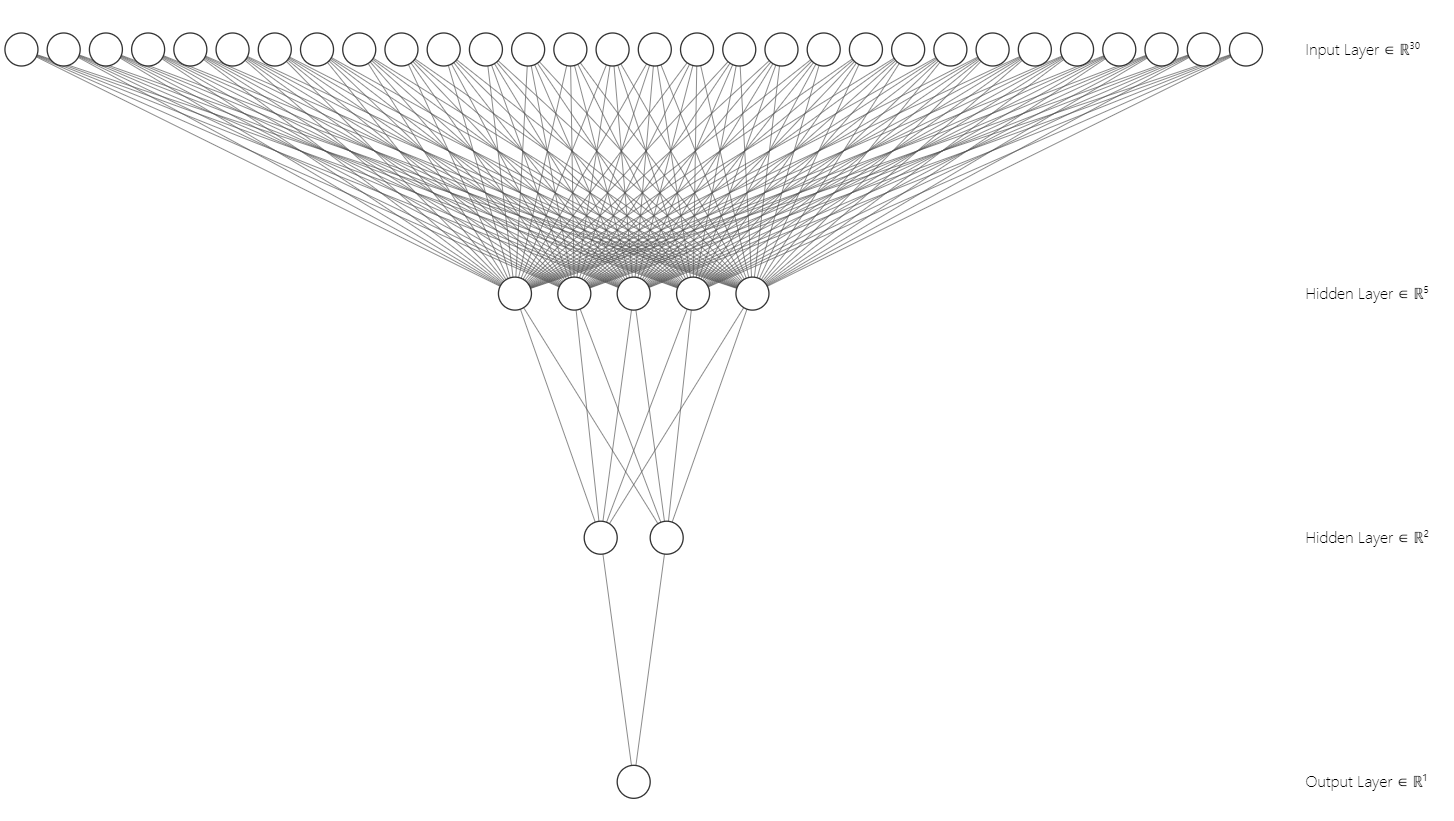

In [ ]:
# Load breast cancer dataset and store as a Pandas dataframe. This code is the same as used in the previous session
cancer = load_breast_cancer()
scaler = preprocessing.StandardScaler().fit(cancer.data) # Define a scaler which standardizes the data to have mean 0 and standard devation 1. This usually improves stability and performance
cancer_data_scaled = scaler.transform(cancer.data) #Use the scaler to transform the training and test data

# Split the dataset into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(cancer_data_scaled, cancer.target, random_state=0)

In [ ]:
# As before, try experimenting with different values for the hyperparameters below:
layers = (5,2) #Change this to any series of integeres > 0 within the parentheses. E.g. (3,8,4)
max_iter = 5000

# Using sklearn train a Neural Network on the scaled cancer data, and compare accuracies
# First define a neural network classifier using the 'adam' optimizer, with two hidden layers with 5 and 2 neurons respectively, with fixed random state of 1
neuralNet = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=layers, max_iter = max_iter, verbose=False, random_state=1)
neuralNet.fit(X_train, y_train) #Fit the neural network to the training set

# Print the training and validation accuracies
print('Training Accuracy: ', neuralNet.score(X_train, y_train))
print('Validation Accuracy: ', neuralNet.score(X_validation, y_validation))

# Plot a confusion matrix to visualize how the neural network performs in terms of true positives, false positives, etc
#fig, ax = plt.subplots()
#plot_confusion_matrix(neuralNet, X_validation, y_validation,
#                                display_labels=['malignant','benign'],
#                                cmap=plt.cm.Blues, ax=ax)
#plt.grid(False)
##plt.show()

Training Accuracy:  0.9859154929577465
Validation Accuracy:  0.972027972027972


Even with arbitrarily chosen neural network hyperparameters (i.e. 5 and then 2 neurons, a single training/validation split, etc.) we achieved better results than the decision tree classifier from the previous session. However, interpreting the weights of the neural network and how each sample is classified is not as easy and therefore requires us to trust that the neural network has learned a meaningful decision algorithm which would generalize to new patient tumors.

Try to scientifically find the best parameters for a neural network for the breast cancer dataset. Use the concept of `for` loops and cross-validation to explore how the training and validation accuracies change. Is the network learning anything useful, is it underfitting or overfitting? You will quickly realize that a neural network is very sensitive to the settings you give it, and it does not take much to get large changes in accuracy. For example, re-run the above neural network code with

# **Supervised Learning**: Convolutional Neural Networks for Classification

Many medical datasets now include images (e.g. patient X-rays, histopathology slides, etc.) Advances in computing have allowed neural network analysis to be extended to images for extremely high accuracy for medical imaging tasks, using convolutional neural networks (CNNs).

We will show you how you can use a very popular CNN library, `PyTorch` (`torch`), to train a simple convolutional neural network architecture to classify between 10 classes of natural images with high accuracy. The code below does not build on any of the `sklearn` functions we have been using above, so read it slowly and carefully to understand it all. The tutorial is adapted from [pytorch.org](https://pytorch.org)

We will use the MedNIST dataset. It has 6 classes: 'hand', 'chest CT', 'abdomen CT', 'breat MRI', 'head CT', 'chest Xray'. The images are of size 3x64x64, i.e. 1-channel grayscale images of 64x64 pixels in size.

**NOTE:** We will be using the free GPU provided by Google Colab for training our CNN. Make sure you go to the menu above, select `Runtime` --> `Change runtime type`, select `GPU` and then save. Restart the runtime and run all cells.

In [ ]:
# Hyperparameters to play around with
batch_size = 4  #How many images the neural network will learn from each iteration
learning_rate = 0.001
train_split = 0.8 #80% of the dataset  should be considered for training

In [ ]:
# Necessary PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.io import read_image
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using {} for training".format(device))

Using cuda:0 for training


In [ ]:
# Download the MedNIST dataset
!git clone https://github.com/apolanco3225/Medical-MNIST-Classification.git

Cloning into 'Medical-MNIST-Classification'...
remote: Enumerating objects: 58532, done.
remote: Total 58532 (delta 0), reused 0 (delta 0), pack-reused 58532
Receiving objects: 100% (58532/58532), 77.86 MiB | 46.84 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Updating files: 100% (58959/58959), done.


In [ ]:
# Summarize the dataset
dataDir = 'Medical-MNIST-Classification/resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 58954 images in 6 distinct categories
Label names: ['ChestCT', 'HeadCT', 'CXR', 'BreastMRI', 'AbdomenCT', 'Hand']
Label counts: [10000, 10000, 10000, 8954, 10000, 10000]
Image dimensions: 64 x 64


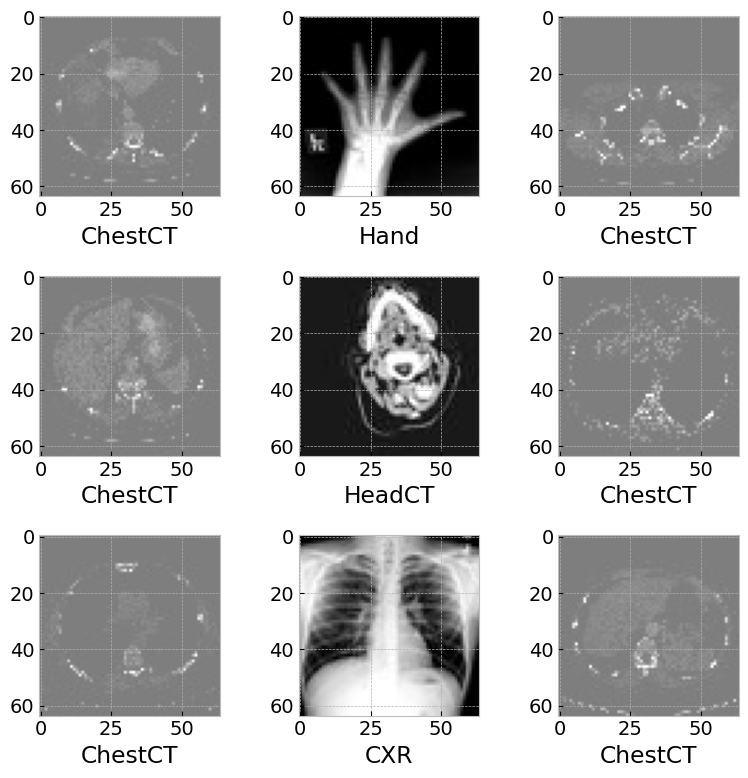

In [ ]:
#Visaulize some images at random
plt.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTotal, size=9)):  # Take a random sample of 9 images and
    im = Image.open(imageFilesList[k])                      #      plot and label them
    arr = np.array(im)
    plt.subplot(3,3,i+1)
    plt.xlabel(classNames[imageClass[k]])
    plt.imshow(arr,cmap='gray',vmin=0,vmax=255)
plt.tight_layout()
plt.show()

In [ ]:
# Write a dataset class which will define how the dataset  is loaded
class MedImageDataset(Dataset):
    def __init__(self, img_files, img_labels, transform=None):
        self.img_files = img_files
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = read_image(self.img_files[idx])
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Call functions to load the data into memory
transform = transforms.Compose(
    [transforms.ToTensor()])

dataset = MedImageDataset(imageFilesList, imageClass)
train_set, test_set = torch.utils.data.random_split(dataset, [int(numTotal*train_split), numTotal-int(numTotal*train_split)])
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
# Lets visualize some of the training set images. Re-run this cell to see new images
# DEPRECATED
# Function to show an image
#def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
#    npimg = img.numpy()
#    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#    plt.show()

# Pick random training images
#dataiter = iter(trainloader)
#images, labels = dataiter.next()

# Show images
#imshow(torchvision.utils.make_grid(images))
# Print labels
#print(' '.join('%5s' % classNames[labels[j]] for j in range(4)))

## Defining our CNN model

PyTorch gives us a lot of flexibility in creating any type of CNN architecture we want. Below, we show have provided typical code to create a very conventional CNN for classifying into 10 categories

In [ ]:
# Define the blueprint for our architecture
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 2704)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create one CNN using our blueprint, put it on the GPU
net = Net(num_classes=numClass)
net.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

## Defining our loss function and optimizer, and training the CNN
Just as with regular neural networks (like the one we trained above on the breast cancer dataset), we need to define an optimizer and loss function which will determine how our CNN learns. We will then create a training loop over which we will measure accuracy on the training and test sets.

In [ ]:
# We will use the multi-class cross entropy loss function
criterion = nn.CrossEntropyLoss()

# We will use the Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

#Now define a training loop which runs for 2 epochs (an epoch is one full run through all the training images)

for epoch in range(2):  # loop over the dataset 2 times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device).float(), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches (i.e. every 8000 images)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.245
[1,  4000] loss: 0.146
[1,  6000] loss: 0.091
[1,  8000] loss: 0.112
[1, 10000] loss: 0.055
[2,  2000] loss: 0.056
[2,  4000] loss: 0.065
[2,  6000] loss: 0.083
[2,  8000] loss: 0.071
[2, 10000] loss: 0.040
Finished Training


In [ ]:
# Evaluate the model's accuracy on the full test set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device).float(), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 99 %


**~99% accuracy over 6 classes** is vert=y good! We can look at the accuracies for each class to see where the network is learning well and where it is underperforming. We can also plot a confusion matrix to get this information.

In [ ]:
class_correct = list(0. for i in range(numClass))
class_total = list(0. for i in range(numClass))
predicted_labels = []
true_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device).float(), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        true_labels.append(labels.detach().cpu().numpy())
        predicted_labels.append(predicted.detach().cpu().numpy())
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(numClass):
    print('Accuracy of %5s : %2d %%' % (
        classNames[i], 100 * class_correct[i] / class_total[i]))



Accuracy of ChestCT : 99 %
Accuracy of HeadCT : 99 %
Accuracy of   CXR : 99 %
Accuracy of BreastMRI : 100 %
Accuracy of AbdomenCT : 99 %
Accuracy of  Hand : 98 %


In [ ]:
np.array(classNames)[np.concatenate(true_labels).flat]
# [np.ravel(true_labels)]

array(['HeadCT', 'Hand', 'ChestCT', ..., 'ChestCT', 'HeadCT', 'BreastMRI'],
      dtype='<U9')

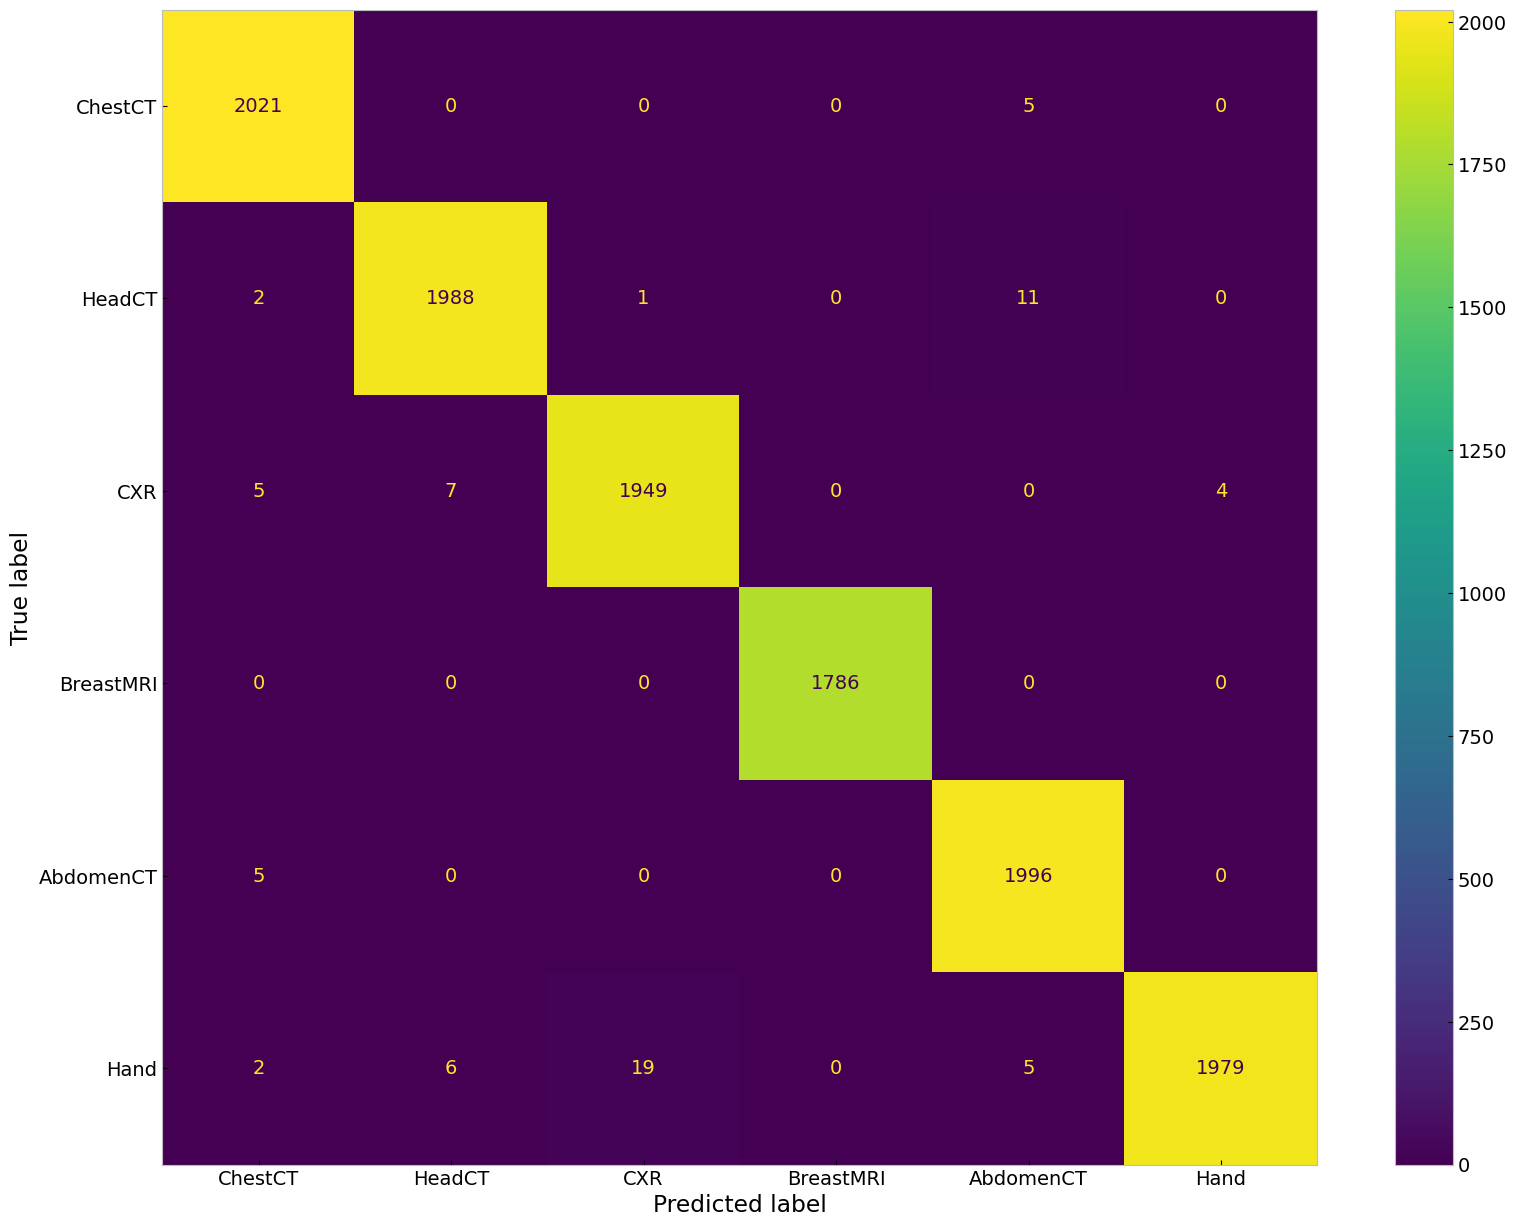

In [ ]:
# Plot confusion matrix - DEPRECATED
cmatrix = confusion_matrix(np.array(classNames)[np.concatenate(true_labels).flat], np.array(classNames)[np.concatenate(predicted_labels).flat], labels=classNames)
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=classNames)
fig,ax = plt.subplots(figsize=[20,15])
disp.plot(ax=ax)
plt.grid(False)
plt.show()

Hopefully this has made you interested in usefulness of machine learning and AI! You should explore other algorithms and datasets out there. In particular, you should read about and play around with CNNs to see how you can improve accuracy. Next time you work on a medical or healthcare related project, you can assess whether machine learning could be used to augment your analysis or create a prediction model.

Good luck!